In [1]:
import wandb
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import pandas as pd

In [2]:
import seaborn as sns

In [3]:
import numpy as np

In [4]:
from typing import Dict

In [5]:
TEXT_WIDTH_INCHES = 6.30045
COL_WIDTH_INCHES = 3.03209

In [6]:
# the names of the tasks we consider (9 in total)
TASKS = [
    "hatecheck",
    "xglue-xnli",
    "xglue-qam",
    "xglue-qadsm",
    "xglue-paws-x",
    "amazon_reviews_multi",
    "xcsr-X-CODAH",
    "xcsr-X-CSQA",
    "winox",
]
print(len(TASKS))

9


In [7]:
# We use F1 when the labels change from sample to sample,
# accuracy when the labels are all the same.
task_to_metric = {
    "xglue-qam": "accuracy",
    "xglue-qadsm": "accuracy",
    "xglue-paws-x": "accuracy",
    "xglue-xnli": "accuracy",
    "xcsr-X-CSQA": "f1",
    "xcsr-X-CODAH": "f1",
    "hatecheck": "accuracy",
    "amazon_reviews_multi": "accuracy",
    "winox": "f1",
}

In [8]:
# we distinguish between these models
MODEL_NAMES = [
    "Sandwich",
    "MetaICL-geWECHSELt",
    "GPT2-geWECHSELt+MetaICLA",
    "GPT2-geWECHSELt+MetaICLVA",
    "MetaICL",
]
print(len(MODEL_NAMES))

5


In [9]:
model_cmap = sns.color_palette("mako_r", 5)

In [10]:
model_to_color = {m: c for m, c in zip(MODEL_NAMES, model_cmap)}

In [11]:
LANGS = ["en", "fr", "de"]
print(len(LANGS))

3


In [12]:
lang_to_hatch = {"de": "..", "fr": "///", "en": None}

In [13]:
def parse_name_from_run(run) -> str:
    """Parses model name from run metadata"""
    if run.config["name"] == "sandwich":
        return "Sandwich"
    elif run.config["name"] == "plain_gpt2":
        if run.config["lang"] == "en":
            return "MetaICL"
        else:
            return "MetaICL-geWECHSELt"
    elif run.config["name"] == "vessel":
        if run.config["adapter_checkpoint"] == "metaicla":
            return "GPT2-geWECHSELt+MetaICLA"
        elif run.config["adapter_checkpoint"] == "metaiclva":
            return "GPT2-geWECHSELt+MetaICLVA"

In [14]:
def parse_run(run) -> Dict:
    """Parses run data into more use-able format"""
    run_info = {
        "lang": run.config["lang"],
        "model_name": parse_name_from_run(run),
        "metrics": {},
        "config": run.config,
    }
    for k, v in run.summary.items():
        potential_candidate = k.split("/")[0]
        if potential_candidate in TASKS and k[-5:] == "epoch":
            task = potential_candidate
            if task not in run_info["metrics"]:
                run_info["metrics"][task] = {}
            if k.split("/")[2][:2] == "f1":
                run_info["metrics"][task]["f1"] = v
            else:
                run_info["metrics"][task]["accuracy"] = v
    return run_info

In [15]:
wandb_api = wandb.Api()

In [16]:
WANDB_ENTITY = "giulio-uva"
WANDB_PROJECT = "claficle"
WANDB_PREFIX = f"{WANDB_ENTITY}/{WANDB_PROJECT}"

In [17]:
wandb_api.entity = WANDB_ENTITY
wandb_api.project = WANDB_PROJECT

In [18]:
runs = wandb_api.runs(WANDB_PREFIX)

In [19]:
eval_runs = [parse_run(run) for run in runs if run.job_type == "eval"]

In [20]:
# for run in eval_runs:
#     if run['lang'] =='en':
#         eng_run = run

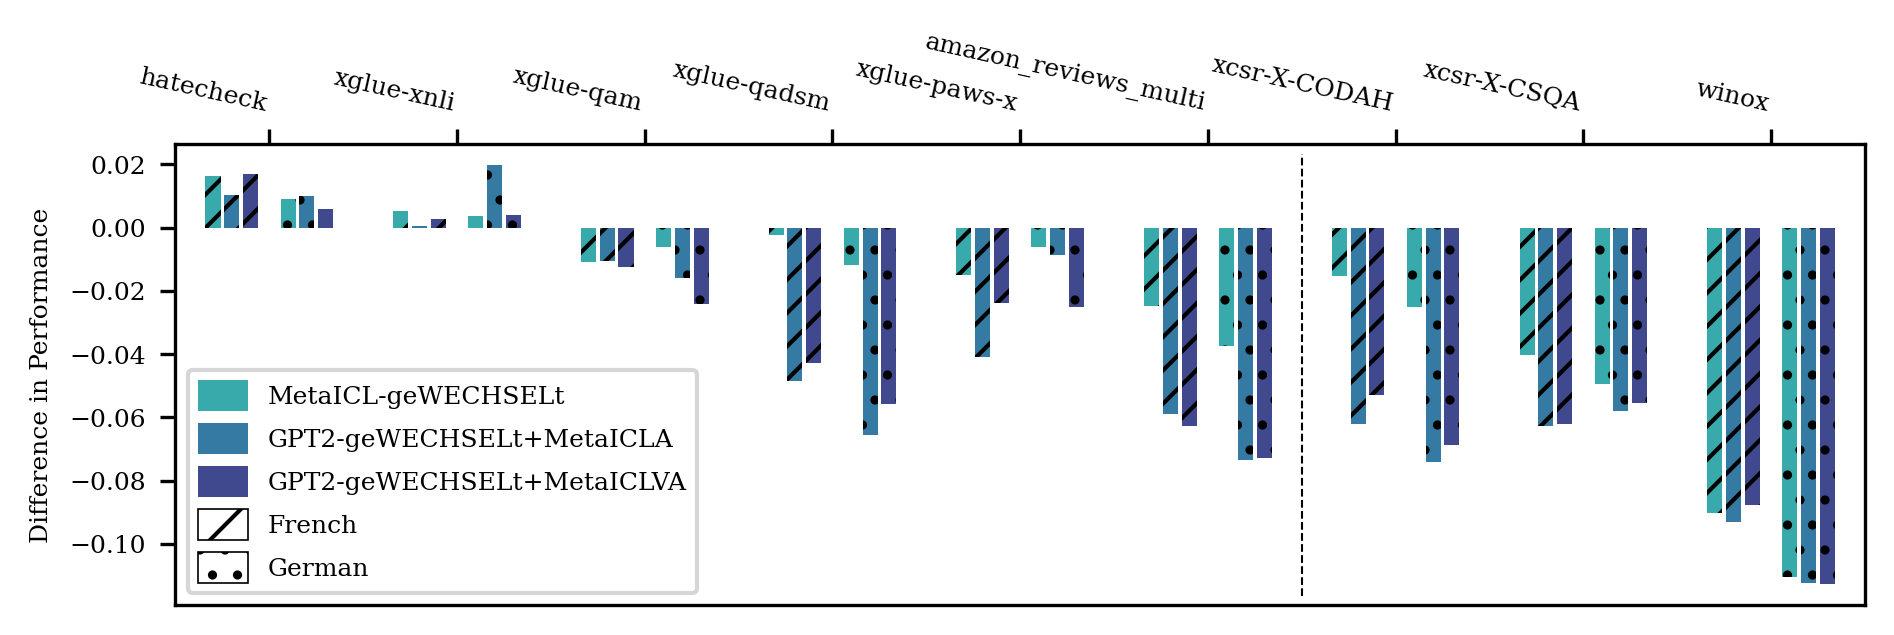

In [21]:
font = {"family": "serif", "size": 6}

matplotlib.rc("font", **font)

f, ax = plt.subplots(1, 1, figsize=(TEXT_WIDTH_INCHES, TEXT_WIDTH_INCHES / 3), dpi=300)
space_bet_langs = 1
space_bet_tasks = 3
num_langs = 2
num_tasks = 9
num_models = 3
task_width = num_langs * num_models + space_bet_tasks + space_bet_langs

differences = {
    "fr": {k: [] for k in MODEL_NAMES[1:-1]},
    "de": {k: [] for k in MODEL_NAMES[1:-1]},
}
for i, task in enumerate(TASKS):
    task_metric = task_to_metric[task]
    for j, lang in enumerate(LANGS[1:]):
        for k, model in enumerate(MODEL_NAMES[1:-1]):
            bar_index = i * task_width + j * (num_models + space_bet_langs) + k
            for run in eval_runs:
                if model == run["model_name"] and lang == run["lang"]:
                    curr_run = run
                if run["model_name"] == "Sandwich" and run["lang"] == lang:
                    sandwich_run = run

            difference = (
                curr_run["metrics"][task][task_metric]
                - sandwich_run["metrics"][task][task_metric]
            )
            differences[lang][model].append(difference)
            bar = ax.bar(
                x=bar_index,
                height=difference,
                align="center",
                color=model_to_color[model],
                hatch=lang_to_hatch[lang],
                # label=model if i == num_tasks - 1 and j == num_langs - 1 else None,
            )
# legend_handles = ax.get_legend_handles_labels()[0]

legend_handles = [
    mpatches.Patch(facecolor=model_to_color[model], label=model)
    for model in MODEL_NAMES[1:-1]
]
fr = mpatches.Patch(
    facecolor="white", hatch="//", edgecolor="black", label="French", linewidth=0.4
)
de = mpatches.Patch(
    facecolor="white", edgecolor="black", hatch="..", label="German", linewidth=0.4
)
legend_handles.extend([fr, de])
ax.legend(handles=legend_handles, handleheight=1.5)
ax.xaxis.tick_top()
ax.set_xlim(-2, 88)
ax.set_ylabel("Difference in Performance")
ax.set_xticks(np.arange(3, 90, 10))
ax.set_xticklabels(TASKS, rotation=-12.5, ha="right")
ax.axvline(x=58, ymax=0.98, ymin=0.02, linewidth=0.5, color="black", linestyle="dashed")
f.set_tight_layout(True)
plt.savefig("../reports/figures/results.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [22]:
for model in MODEL_NAMES[1:-1]:
    lang_averages = []
    for lang in ['fr', 'de']:
        lang_average = sum(differences[lang][model]) / num_tasks
        lang_averages.append(lang_average)
        print(model, lang, lang_average)
    print(model, 'overall', sum(lang_averages) / 2)
    print("---")

MetaICL-geWECHSELt fr -0.019728442033131923
MetaICL-geWECHSELt de -0.025995988812711496
MetaICL-geWECHSELt overall -0.02286221542292171
---
GPT2-geWECHSELt+MetaICLA fr -0.04068472733100256
GPT2-geWECHSELt+MetaICLA de -0.04202553878227869
GPT2-geWECHSELt+MetaICLA overall -0.041355133056640625
---
GPT2-geWECHSELt+MetaICLVA fr -0.03604956012633112
GPT2-geWECHSELt+MetaICLVA de -0.044972375863128224
GPT2-geWECHSELt+MetaICLVA overall -0.04051096799472967
---


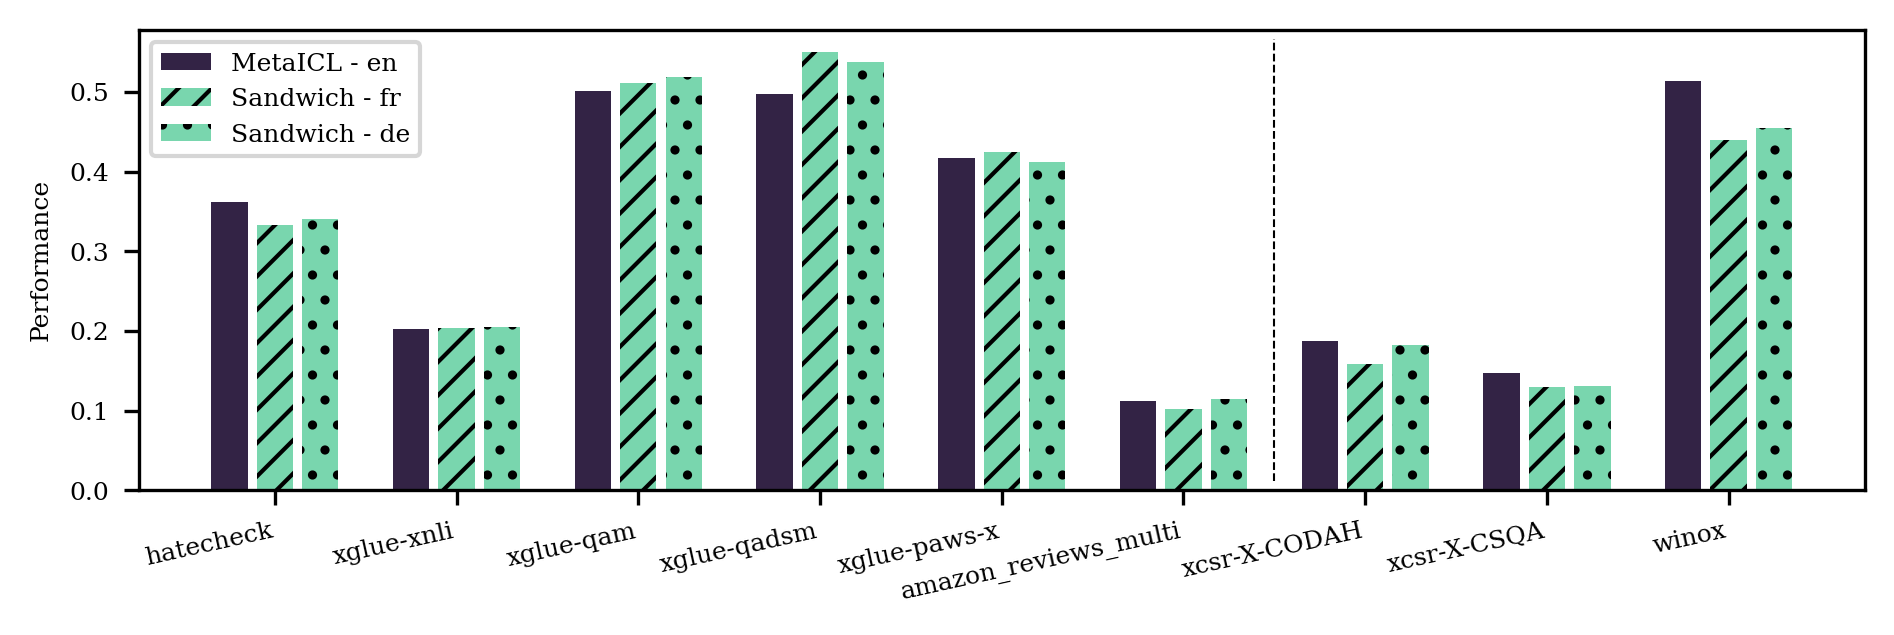

In [23]:
font = {"family": "serif", "size": 6}

matplotlib.rc("font", **font)

bars_per_task = 3
space_bet_tasks = 1
task_width = bars_per_task + space_bet_tasks

f, ax = plt.subplots(1, 1, figsize=(TEXT_WIDTH_INCHES, TEXT_WIDTH_INCHES / 3), dpi=300)

metrics = {"MetaICL": {"en": []}, "Sandwich": {"fr": [], "de": []}}
for i, task in enumerate(TASKS):
    task_metric = task_to_metric[task]
    for j, lang in enumerate(LANGS):
        bar_index = task_width * i + j
        for model in ("MetaICL", "Sandwich"):
            for run in eval_runs:
                if run["model_name"] == model and run["lang"] == lang:
                    metric = run["metrics"][task][task_metric]
                    metrics[model][lang].append(metric)
                    ax.bar(
                        bar_index,
                        metric,
                        hatch=lang_to_hatch[lang],
                        color=model_to_color[model],
                        label=f"{model} - {lang}" if i == num_tasks - 1 else None,
                    )
ax.legend()
ax.set_xlim(-2, 36)
ax.set_ylabel("Performance")
ax.set_xticks(np.arange(1, 36, 4))
ax.set_xticklabels(TASKS, rotation=12.5, ha="right")
ax.axvline(x=23, ymax=0.98, ymin=0.02, linewidth=0.5, color="black", linestyle="dashed")
f.set_tight_layout(True)
plt.savefig("../reports/figures/baselines.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [24]:
for model in ["MetaICL", "Sandwich"]:
    for lang in LANGS:
        if lang in metrics[model]:
            lang_average = sum(metrics[model][lang]) / 9 
            print(model, lang, lang_average)

MetaICL en 0.3267351860801379
Sandwich fr 0.3170485297838847
Sandwich de 0.3216818306181166
